In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#Import portfolio equity data from spreadsheet in Google Drive
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTiWef8U4l6IcxSs_weyfgi4yK31-CKPM8MMkRAg6odW5bdDpDKzlT9NGs5ItNMGT1JSsN28azhWcPO/pub?gid=2067999169&single=true&output=csv')
df.head()

,Date,BTCUSD,ETHUSD
0,1451624400,100000.0,100000.0
1,1451700000,100000.0,100000.0
2,1451793600,100000.0,100000.0
3,1451883600,100000.0,100000.0
4,1451970000,100000.0,100000.0


In [ ]:
#converting unix timestamp into regular date format
df['Date']= pd.to_datetime(df['Date'], unit='s').dt.date
df.head()

,Date,BTCUSD,ETHUSD
0,2016-01-01,100000.0,100000.0
1,2016-01-02,100000.0,100000.0
2,2016-01-03,100000.0,100000.0
3,2016-01-04,100000.0,100000.0
4,2016-01-05,100000.0,100000.0


In [ ]:
#setting index to 'Date' column
df = df.set_index(pd.to_datetime(df['Date']))
df = df.drop('Date', axis=1)
df.head()

,BTCUSD,ETHUSD
Date,,
2016-01-01,100000.0,100000.0
2016-01-02,100000.0,100000.0
2016-01-03,100000.0,100000.0
2016-01-04,100000.0,100000.0
2016-01-05,100000.0,100000.0


Plotting Stock Price Graph

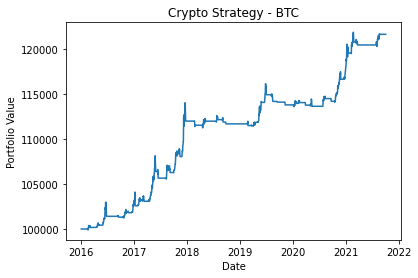

In [ ]:
plt.plot(df['BTCUSD'])
plt.title('Crypto Strategy - BTC')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

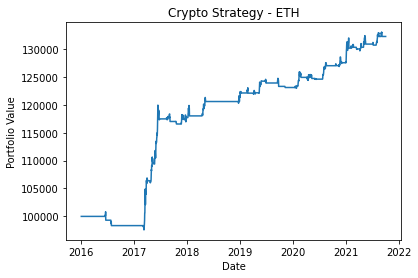

In [ ]:
plt.plot(df['ETHUSD'])
plt.title('Crypto Strategy - ETH')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

In [ ]:
#Co-variance matrix
# Log of percentage change
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()

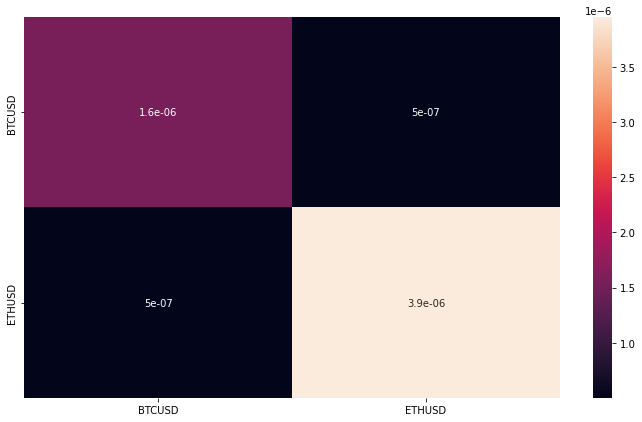

In [ ]:
plt.figure(figsize=(12,7))
cov_matrix_plot = sns.heatmap(cov_matrix, annot=True)

In [ ]:
#Correlation matrix
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()

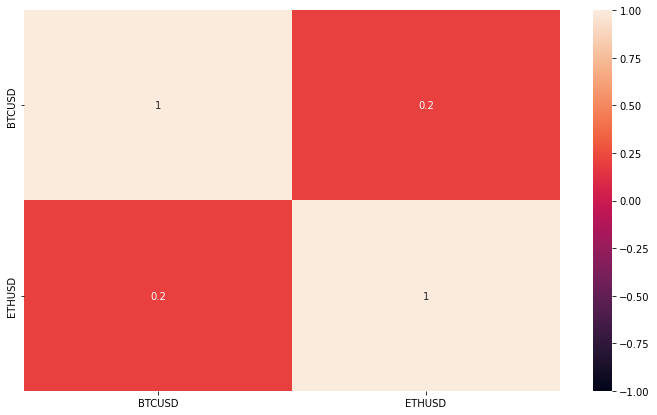

In [ ]:
plt.figure(figsize=(12,7))
corr_matrix_plot = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)

Annual Returns

In [ ]:
# Yearly returns for individual assets/strategies
ind_er = df.resample('Y').last().pct_change().mean() #for more than 1 year
ind_er

BTCUSD    0.034274
ETHUSD    0.063041
dtype: float64

Volatility

In [ ]:
# Converting daily standard deviation to annual standard deviation
# Volatility is given by the annual standard deviation. We multiply by 252 because there are 252 trading days/year.
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
ann_sd

BTCUSD    0.019822
ETHUSD    0.031549
dtype: float64

Comparison of Returns & Volatility of Assets/Strategies

In [ ]:
# Creating a table for visualising returns and volatility of assets/strategies
assets = pd.concat([ind_er, ann_sd], axis=1) 
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
BTCUSD,0.034274,0.019822
ETHUSD,0.063041,0.031549


Plotting Efficient Frontier

In [ ]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset/strategy weights

num_assets = len(df.columns)
num_portfolios = 100000 #number of portfolios to plot 

In [ ]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its weights 
    p_ret.append(returns)
    
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(252) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [ ]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [ ]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the number of portfolios(num_portfolios) created

,Returns,Volatility,BTCUSD weight,ETHUSD weight
0,0.049582,0.020752,0.467869,0.532131
1,0.048016,0.019931,0.522307,0.477693
2,0.045229,0.018827,0.619165,0.380835
3,0.049809,0.020882,0.459982,0.540018
4,0.041805,0.018196,0.738209,0.261791


Plot Efficient Frontier

Text(0, 0.5, 'Returns')

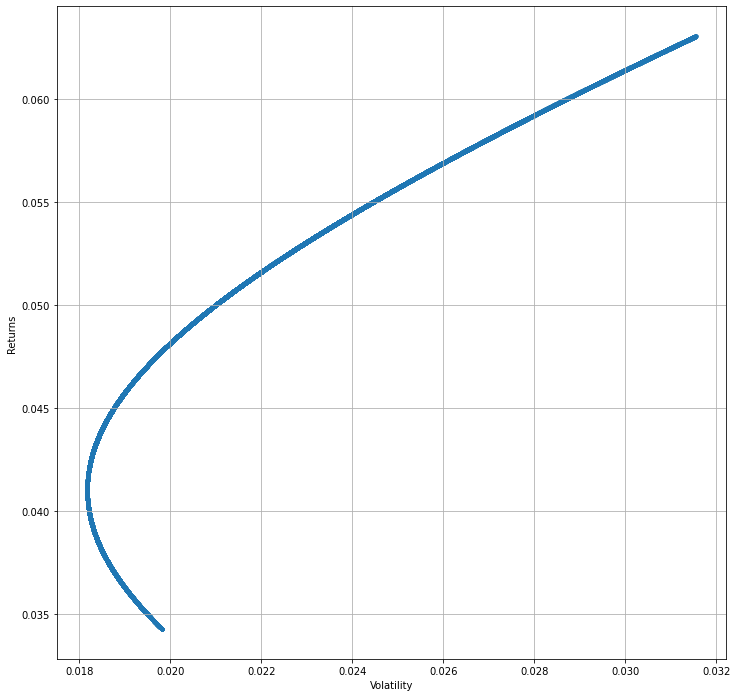

In [ ]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[12,12])
plt.xlabel('Volatility')
plt.ylabel('Returns')

Getting Weights for Lowest Volatility (Lowest Risk Optimal Portfolio)

In [ ]:
#Getting parameter/weights of the point with minimum volatility
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns          0.041030
Volatility       0.018173
BTCUSD weight    0.765161
ETHUSD weight    0.234839
Name: 50456, dtype: float64

In [ ]:
assets

,Returns,Volatility
BTCUSD,0.034274,0.019822
ETHUSD,0.063041,0.031549


In [ ]:
#Sharpe Ratio of minimally volatile portfolio
sharpe_ratio_min_vol = min_vol_port[0] / min_vol_port[1]
sharpe_ratio_min_vol

2.257737660759138

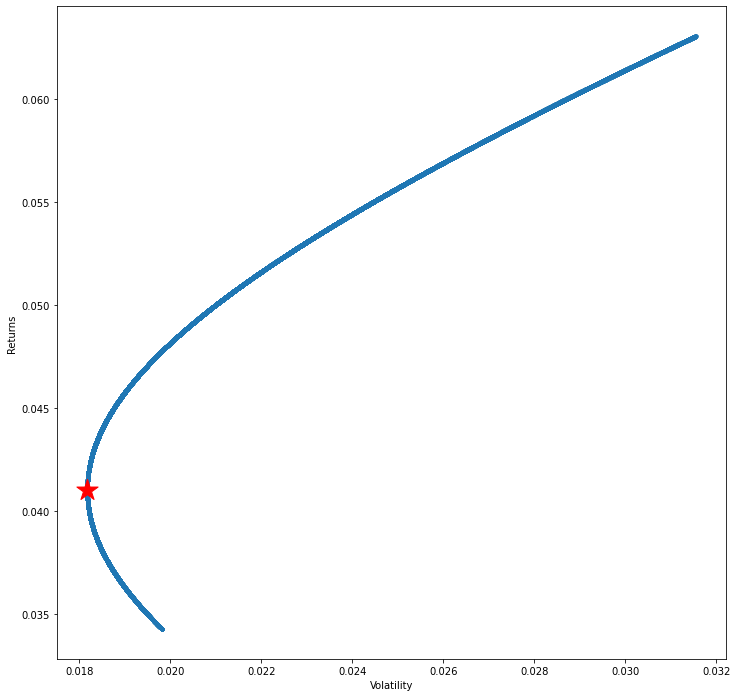

In [ ]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[12,12])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

Getting Weights for Highest Sharpe Ratio (Highest Risk Optimal Portfolio)

In [ ]:
# Finding the optimal portfolio (i.e. Highest Sharpe Ratio)

# risk factor(risk-free rate)
rf = 0.0161  #1.61% Average return of Singapore Savings Bonds over 10 years https://www.mas.gov.sg/bonds-and-bills/Singapore-Savings-Bonds

optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns          0.050680
Volatility       0.021403
BTCUSD weight    0.429680
ETHUSD weight    0.570320
Name: 36954, dtype: float64

In [ ]:
assets

,Returns,Volatility
BTCUSD,0.034274,0.019822
ETHUSD,0.063041,0.031549


In [ ]:
#Sharpe Ratio of Optimally risky portfolio
sharpe_ratio_risky = optimal_risky_port[0] / optimal_risky_port[1]
sharpe_ratio_risky

2.367874574180811

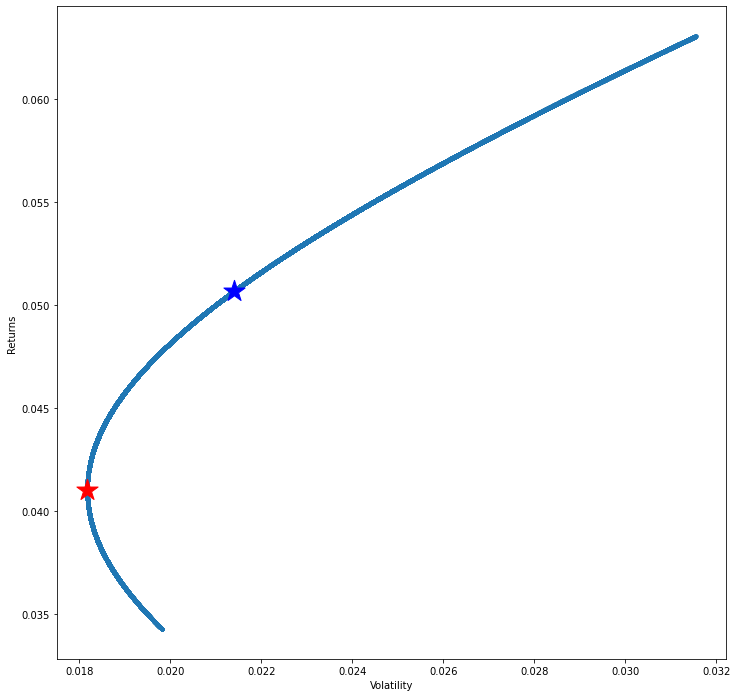

In [ ]:
# Plotting optimal portfolio (Blue Star)
plt.subplots(figsize=(12, 12))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='b', marker='*', s=500)

To Extract Table Data (Returns Volatility Weights)

In [ ]:
portfolios

,Returns,Volatility,BTCUSD weight,ETHUSD weight
0,0.049582,0.020752,0.467869,0.532131
1,0.048016,0.019931,0.522307,0.477693
2,0.045229,0.018827,0.619165,0.380835
3,0.049809,0.020882,0.459982,0.540018
4,0.041805,0.018196,0.738209,0.261791
...,...,...,...,...
99995,0.062580,0.031109,0.016023,0.983977
99996,0.057773,0.026741,0.183117,0.816883
99997,0.056043,0.025291,0.243270,0.756730
99998,0.036479,0.018939,0.923359,0.076641


In [ ]:
portfolios.to_csv('portfolios.csv', index=False)

Click "Files" icon on Left tab to download csv